# Определение стоимости автомобилей

Описание проекта

Компания по продаже автомобилей с пробегом разрабатывает мобильное приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

**Наша задача** - построить модель, которая умеет определять рыночную стоимость автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

Для оценки качества моделей применим метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Ход исследования:**

Данные для исследования мы получим из файла, предоставленного заказчиком.

**Описание данных**

Признаки

DateCrawled — дата скачивания анкеты из базы   
VehicleType — тип автомобильного кузова   
RegistrationYear — год регистрации автомобиля   
Gearbox — тип коробки передач   
Power — мощность (л. с.)   
Model — модель автомобиля   
Kilometer — пробег (км)   
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива   
Brand — марка автомобиля   
Repaired — была машина в ремонте или нет   
DateCreated — дата создания анкеты   
NumberOfPictures — количество фотографий автомобиля   
PostalCode — почтовый индекс владельца анкеты (пользователя)   
LastSeen — дата последней активности пользователя   
Целевой признак

Price — цена (евро)   

**Исследование пройдет в 6 этапов:**

1.Загрузка и первичное изучение данных;

2.Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.

3.Подготовим выборки для обучения моделей.

4.Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.

5.Чтобы усилить исследование, не будем ограничиваться градиентным бустингом. Попробуем более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.
Поэкспериментируем и сравним характеристики моделей: время обучения, время предсказания, точность результата.
Проанализируем время обучения, время предсказания и качество моделей.

6.Общий вывод

## Подготовка данных

В целях подготовки и изучения данных проведем исследовательский анализ данных (EDA), который состоит из следующих этапов:

* изучим целевой признак   
* изучим признаки для обучения   
* изучим влияние признаков на таргет   


### Импортируем необходимые для анализа библиотеки и структуры данных для каждой модели


Считаем данные из csv-файла в датафрейм и сохраним в переменную data.


In [1]:
# импорт библиотек
!pip install scikit-learn==1.1.3
!pip install CatBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

import lightgbm

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


from catboost import CatBoostRegressor,cv
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')


In [4]:
# выберем стиль для оформления графиков
plt.style.use('fivethirtyeight')

In [5]:
# напишем функцию для вывода основной информации о датасете
def main_info(data):
    print('Выведем первые 5 строк датафрейма')
    display(data.head())
    print()

    print('Основная информация о датафрейме')
    print()
    display(data.info())
    print()

    print('Числовое описание данных')
    display(data.describe())
    print()

    print('Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print('Количество пропусков')
    display((data.isna().sum() / len(data) * 100).sort_values(ascending=False).head(10))
    print()

    print('Тип признаков')
    print(data.dtypes)


In [6]:
main_info(data)

Выведем первые 5 строк датафрейма


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-nul

None


Числовое описание данных


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Количество строк-дубликатов


4


Количество пропусков


Repaired            20.079070
VehicleType         10.579368
FuelType             9.282697
Gearbox              5.596709
Model                5.560588
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
dtype: float64


Тип признаков
DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object


После первичного обзора исходного датасета, мы выяснили следующее:

- датасет содержит 354369 объектов и 16 столбцов(признаков);  
- в названиях колонок видны нарушения стиля(есть прописные буквы), при этом соответствуют первоначальному описанию данных;
- типы данных: 7 столбцов это численные признаки(int64) и 9 столбцов это категориальные(object);   
- в данных обнаружены пропуски:20.07% столбец Repared, 10.57% - VehicleType, 9.28% - FuelType, и около 5.6% - GearBox,Model(обработаем позднее);
- есть 4 строки с дубликатами;
- из числового описания данных видно, что в столбце NumberOfPictures значения отсутствуют, следовательно этот столбец неинформативный и его можно сразу удалить;
- целевой признак в столбце Price(цена в евро), остальные признаки будут участвовать в предсказании стоимости.

Перед нами стоит задача регрессии. Проведем более детальный анализ наших признаков.


In [7]:
# удалим неинформативные столбцы
data = data.drop('NumberOfPictures', axis= 1)
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21



### Изучим целевой признак

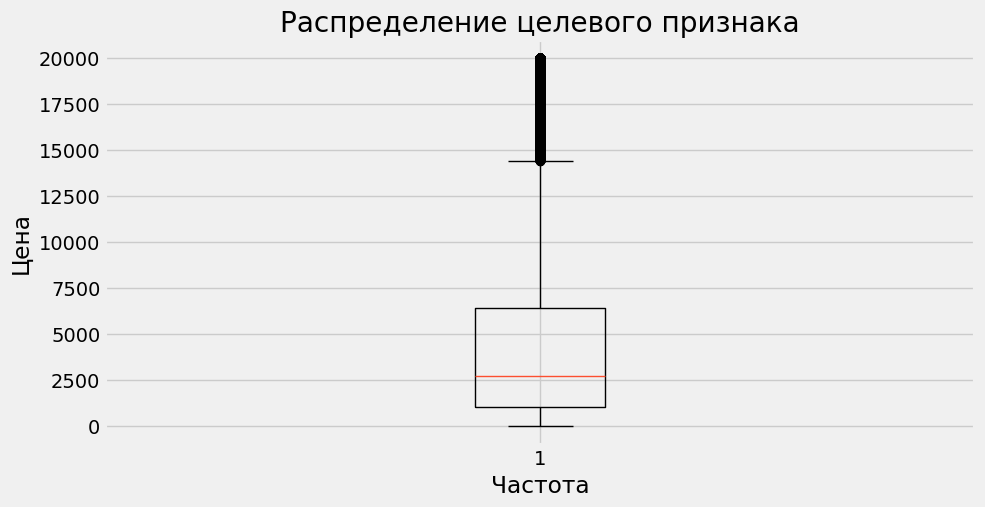

In [8]:
plt.figure(figsize=(10,5))
plt.boxplot(data['Price']);
plt.title ('Распределение целевого признака');
plt.xlabel ('Частота');
plt.ylabel ('Цена');

In [9]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [10]:
data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

Мы видим, что на отметке свыше 14500 евро находятся аномальные значения, но в целевом признаке мы их убирать не будем, т.к. думаю есть автомобили с достаточно высокой стоимостью, просто их не так много (около 4,5%) по сравнению с общей массой. В среднем автомобили оцениваются в 4416 евро, но медиана при этом 2700 евро.
Также в данных обнаружены нулевые значения, около 3% от общего количества. Удалим их из наших данных, чтобы они не испортили нашу модель.

In [11]:
# удалим нулевые значения из таргета и оставим значения свыше 100 евро
data = data[data['Price'] > 100]

In [12]:
# проверим
data['Price'].describe()

count    340024.000000
mean       4602.471902
std        4514.902742
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

### Изучим признаки

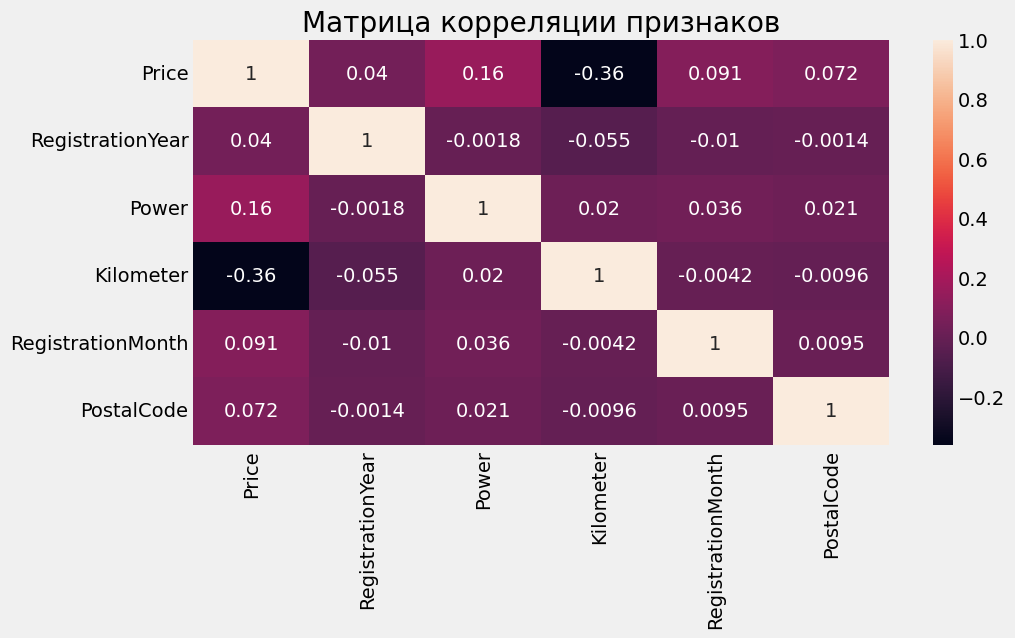

In [13]:
# построим матрицу корреляции остальных количественных признаков

plt.figure(figsize=(10,5))
plt.title('Матрица корреляции признаков')
sns.heatmap(data.corr(), annot = True)

plt.show()

В целом мы видим достаточно слабую корреляцию между признаками. За исключением признака Пробег(Kilometer) - здесь наблюдается отрицательная корреляция с ценой на авто, что говорит нам о том, что при увеличении пробега стоимость автомобиля снижается, что является очевидным.

**Рассмотрим категориальные признаки.**

**Тип автомобильного кузова (`VehicleType`)**

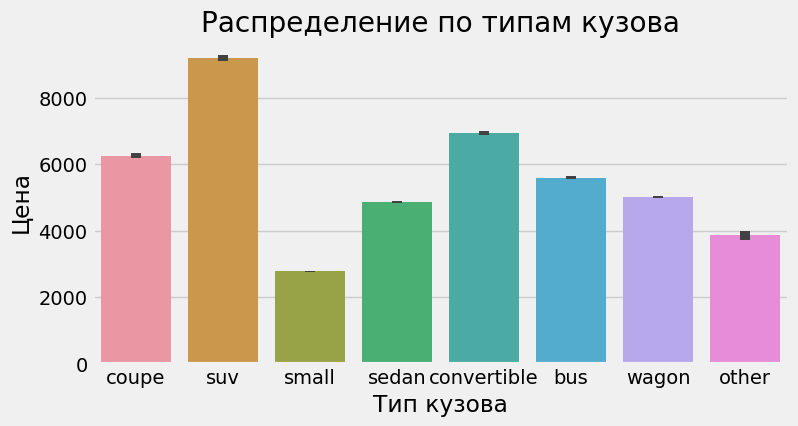

In [14]:
# построим барплот зависимости цены от типа кузова
plt.figure(figsize=(8,4))

sns.barplot(x=data['VehicleType'],y=data['Price']);
plt.title ('Распределение по типам кузова');
plt.xlabel ('Тип кузова');
plt.ylabel ('Цена');
plt.show()

Видим, что цена зависит от типа кузова. Самые дорогие это спортивные авто это с типом кузова - suv,за ними следуют купе и  самые дешевые с типом кузова - small.

In [15]:
# отсортируем уникальные значения в типе кузова автомобиля
data['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

Ранее мы уже выяснили, что в данном столбце есть около 10% пропусков. Удалять полностью строки, где есть значения Nan в столбце `VehicleType` будем считать нецелесообразным, т.к. можем удалить важные сведения для прогноза из других столбцов. Поэтому заменим Nan на значение `other`, посчитаем что эти данные просто не указаны при подаче объявления.

In [16]:
data['VehicleType'] = data['VehicleType'].fillna('other')

In [17]:
# проверим
data['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon'], dtype=object)

**Год регистрации автомобиля (`RegistrationYear`)**

In [18]:
# отсортируем уникальные значения в годе регистрации автомобиля
data['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2290, 2500,
       2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000,
       5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800, 8200, 8500,
       8888, 9000, 9450, 9999])

In [19]:
# посчитаем сколько значений в годе регистрации автомобиля меньше 1910 года
(data['RegistrationYear'] <= 1910).value_counts()

False    339950
True         74
Name: RegistrationYear, dtype: int64

In [20]:
# посчитаем сколько значений в годе регистрации автомобиля больше 2066 года
(data['RegistrationYear'] >= 2066).value_counts()

False    339953
True         71
Name: RegistrationYear, dtype: int64

In [21]:
# оставим в датасете только строки с годом больше 1910 и меньше 2066
data = (data[(data['RegistrationYear'] >= 1910) & (data['RegistrationYear'] <= 2016)])
# проверим наши значения
data['RegistrationYear'].sort_values().unique()

array([1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

Год регистрации авто должен быть меньше даты скачивания анкеты из базы. Далее я посмотрела период размещения объявлений, это 2015 и 2016 гг. Следовательно год регистрации свыше 2016 г уберем.


Сразу же рассмотрим столбец `RegistrationMonth`(месяц регистрации автомобиля). Считаю, что данный столбец не несет никакой важной информации при определении стоимости авто, поэтому удалим его полностью. Тем более, что у нас останется год регистрации машины.

In [22]:
# удалим столбец `RegistrationMonth`
data = data.drop('RegistrationMonth', axis= 1)

**Тип коробки передач (Gearbox)**

In [23]:
# посмотрим уникальные значения в столбце с типом коробкт передач
data['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

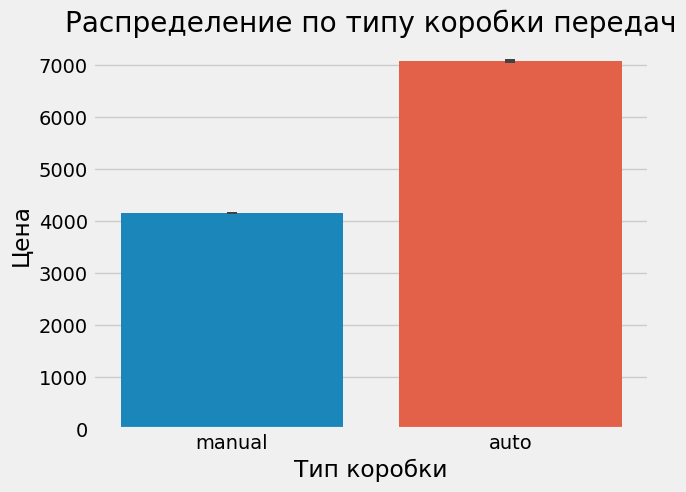

In [24]:
plt.figure()

sns.barplot(x=data['Gearbox'],y=data['Price']);
plt.title ('Распределение по типу коробки передач');
plt.xlabel ('Тип коробки');
plt.ylabel ('Цена');
plt.show()


Дороже являются автомобили с автоматической коробкой. В данных также есть пропуски, около 5,6%. Удалим их полностью.

In [25]:
# удалим Nan из столбца 'Gearbox'
data = data.dropna(subset=['Gearbox'])

In [26]:
# проверим значения
data['Gearbox'].sort_values().unique()

array(['auto', 'manual'], dtype=object)

**Мощность, л.с.(`Power`)**

In [27]:
data['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Столбец с мощностью содержит довольно нестандартные значения для мощности. Исходя из того, что в среднем у современных машин мощность составляет 120 л.с., а также на сегодняшний момент самый мощным легковым авто является автомобиль с мощностью 2028 л.с, отсортируем наши значения в соответствии с этим данными, взяв за минимальное значение около 80 л.с.(думаю еще остались маломощные авто).

In [28]:
# отсортируем значения
data = (data[(data['Power'] >= 80) & (data['Power'] < 2018)])

**Модель автомобиля (`Model`)**

In [29]:
# посмотрим уникальные значения
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000',
       '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse',
       'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok',
       'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo',
       'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster',
       'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max',
       'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival',
       'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'civic', 'cl',
       'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba',
       'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore',
       'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato',
       'duster', 'e_klasse', 'eos', 'escort', 'espace', 'exeo', 'fabia',
       'fiesta', 

В столбце с моделями автомобилей есть около 5,6 % пропусков (выяснили ранее). Удалим их.

In [30]:
# удалим строки с пропущенными значениями в столбце
data = data.dropna(subset=['Model'])
# проверим все ли удалилось
data['Model'].isna().sum()

0

**Пробег (`Kilometer`)**

In [31]:
# посмотрим уникальные значения по пробегу авто
data['Kilometer'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

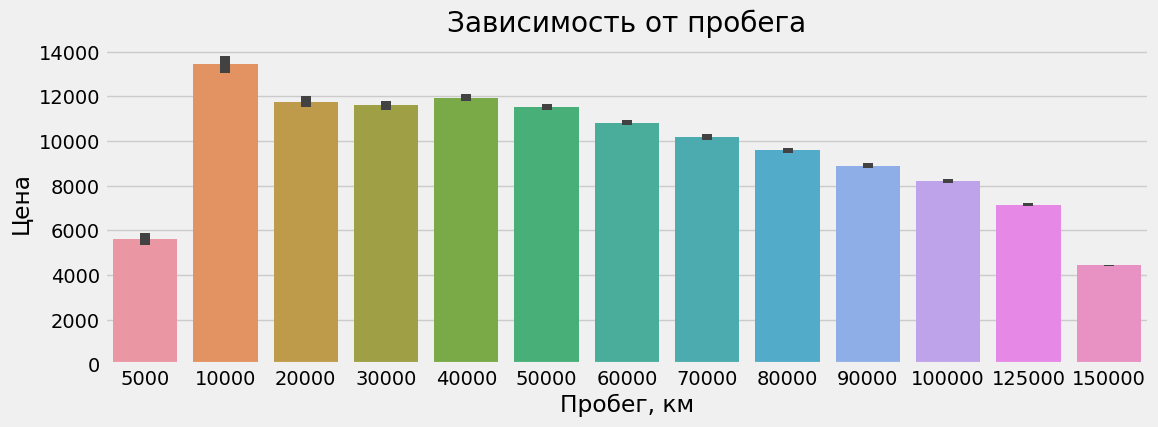

In [32]:
# построим барплот зависимости цены от пробега
plt.figure(figsize=(12,4))

sns.barplot(x=data['Kilometer'],y=data['Price']);
plt.title ('Зависимость от пробега');
plt.xlabel ('Пробег, км');
plt.ylabel ('Цена');
plt.show()

Здесь мы видим ярко выраженную зависимость стоимости авто от пробега, чем больше пробег тем ниже стоимость. Исключение составляют значения 10 тыс.км, у данных автомобилей самая высокая стоимость, видимо из-за малого пробега считается, что автомобиль почти новый. Но на практике так бывает не всегда. Возможно пробег маленький из-за того, что это вторая машина в семье или ей пользуются только в летнее время. Поэтому здесь надо смотреть на год регистрации авто.

**Тип топлива (`FuelType`)**

In [33]:
data['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

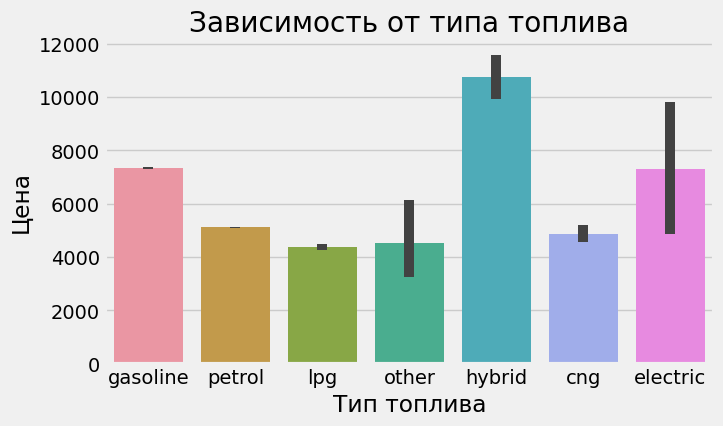

In [34]:
# построим барплот зависимости цены от пробега
plt.figure(figsize=(7,4))

sns.barplot(x=data['FuelType'],y=data['Price']);
plt.title ('Зависимость от типа топлива');
plt.xlabel ('Тип топлива');
plt.ylabel ('Цена');
plt.show()

На графике мы видим, что самыми дорогим являются гибридные авто, далее следуют электрические и на 3-м месте уже бензиновые.
Также ранее мы выяснили, что в данных есть 9,3% пропусков. Заполним их значением неизвестно 'other'.

In [35]:
data['FuelType'] = data['FuelType'].fillna('other')
# проверим остались ли пропуски
data['FuelType'].isna().sum()

0

**Марка автомобиля (`Brand`)**

In [36]:
# посмотрим уникальные значения по маркам авто
data['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo'], dtype=object)

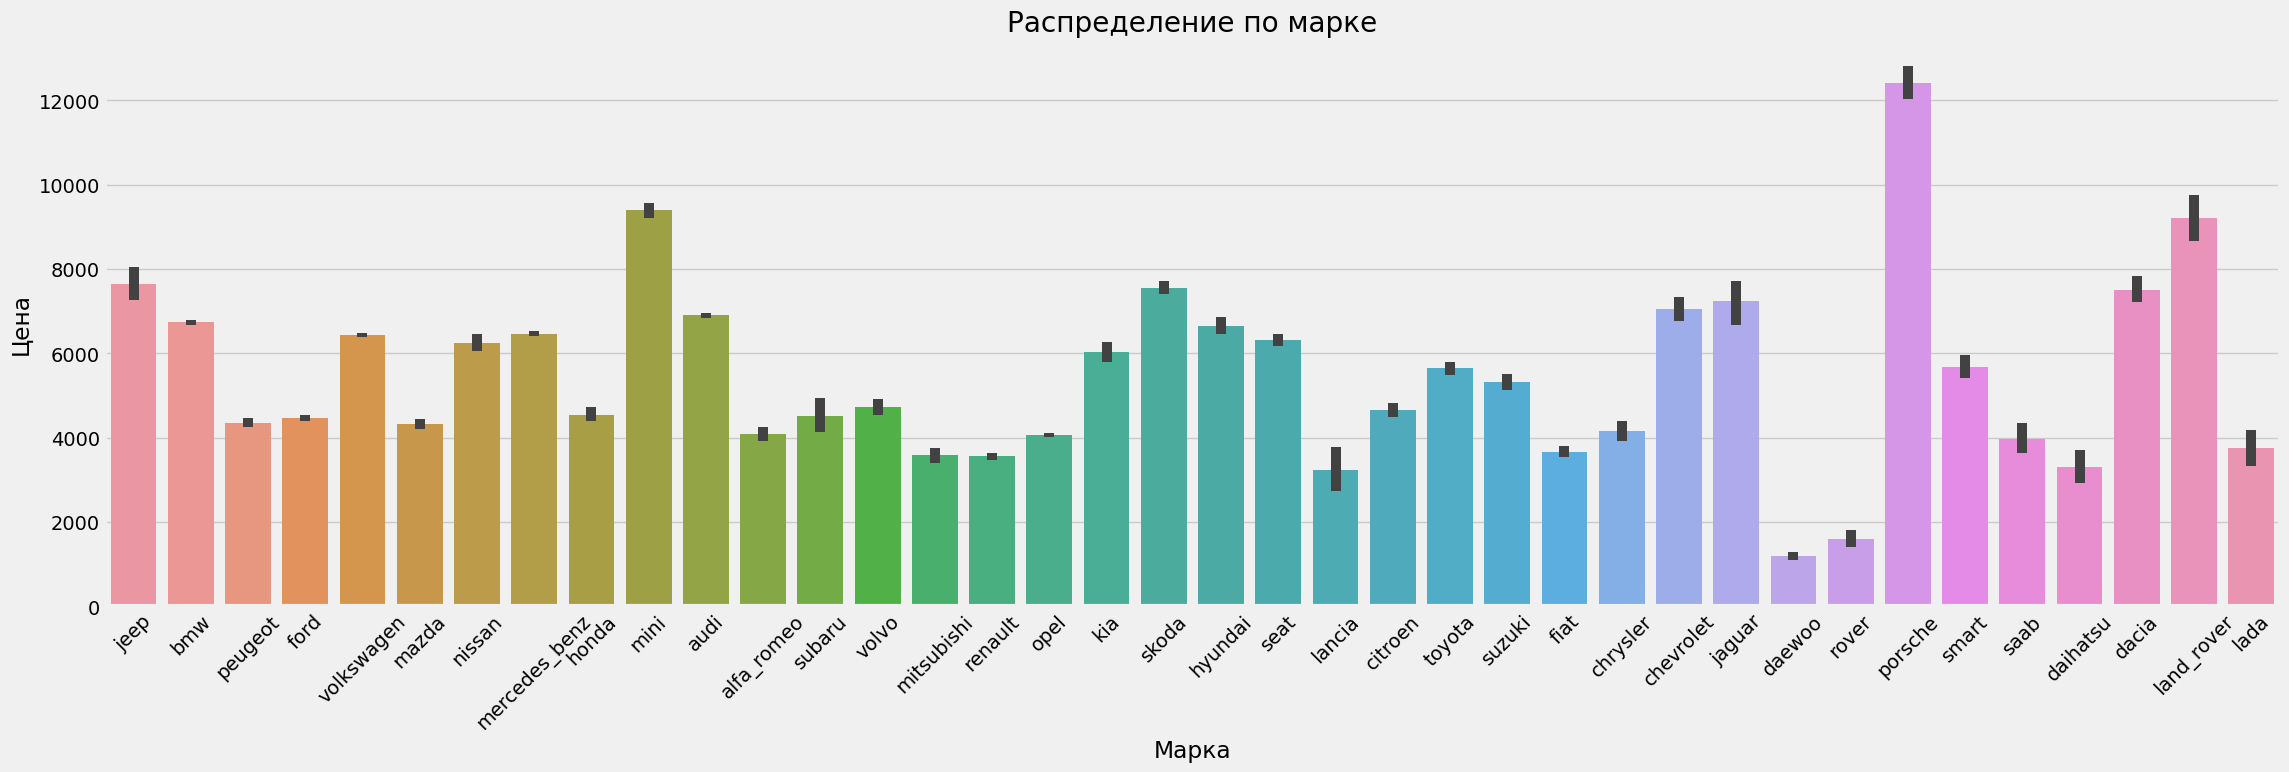

In [37]:
# построим барплот зависимости цены от марки
plt.figure(figsize=(25,7))

sns.barplot(x=data['Brand'],y=data['Price']);
plt.title ('Распределение по марке');
plt.xlabel ('Марка');
plt.ylabel ('Цена');
plt.xticks(rotation = 45)
plt.show()

Самыми дорогими являются автомобили марки 'porsche', далее идут 'mini' и на третьем месте 'land_rover'. Самые дешевые - 'daewoo'.

**Была ли машина в ремонте или нет (`Repaired`)**

In [38]:
data['Repaired'].value_counts()


no     166171
yes     18809
Name: Repaired, dtype: int64

In [39]:
data['Repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Ранее мы выяснили, что процент пропусков в этом столбце составляет около 20%. Мы имеем только 2 уникальных значения (да или нет). Причина пропусков нам неизвеста, можно предположить, что там где есть пропуски ремонта не было и поэтому нет никакой информации. Но это может изменить предсказания модели. Поэтому заполним отсутствующие значения на 'unknown'.

In [40]:
data['Repaired'] = data['Repaired'].fillna('unknown')

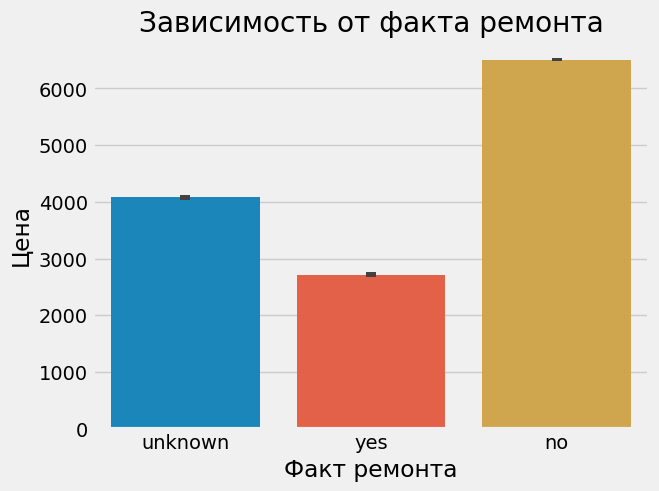

In [41]:
# построим барплот зависимости цены от того,была ли машина в ремонте или нет
plt.figure()

sns.barplot(x=data['Repaired'],y=data['Price']);
plt.title ('Зависимость от факта ремонта');
plt.xlabel ('Факт ремонта');
plt.ylabel ('Цена');
plt.show()

Здесь мы видим высокую зависимость цены от того, была ли машина в ремонте или нет. Те автомобили, которые не были в ремонте стоят значительно дороже.

Рассмотрим столбцы, которые подлежат удалению, в связи с тем, что не несут никакой значимой для прогнозирования информации: `DateCrawled`,`DateCreated` - даты скачивания анкеты из базы и создания анкеты, можно удалить;`PostalCode` - почтовый индекс владельца анкеты, возможно есть какая-то зависимость от региона где находится владелец анкеты, но вряд ли этот столбец окажет решающее влияние на цену, скорее модель на нем переучится; `LastSeen`- дата последней активности лучше тоже исключить, т.к.он неинформативен для наших целей.

Перед удалением столбцов рассмотрим уникальные значения.

In [42]:
# приводим к типу "дата"

data['DateCreated'] = data['DateCreated'].astype('datetime64')

# получаем информацию о годе
data['created_year'] = data['DateCreated'].dt.year

# получаем информацию о месяце
data['created_month'] = data['DateCreated'].dt.month

# получаем информацию о дне недели
data['created_day'] = data['DateCreated'].dt.dayofweek

In [43]:
data["created_year"].sort_values().unique()

array([2015, 2016])

In [44]:
data["created_month"].sort_values().unique()

array([ 1,  2,  3,  4,  8,  9, 11, 12])

In [45]:
data["created_month"].sort_values().unique()

array([ 1,  2,  3,  4,  8,  9, 11, 12])

 Добавила анализ временного периода. Здесь можно сказать, что у нас есть данные по объявлениям размещенным в 2015 и 2016 годах. Анкеты создавались на протяжении почти всего года, за исключением летнего периода.

Признаки `DateCrawled`,`DateCreated`,`PostalCode`,`LastSeen` считаем неинформативными и удалим их из наших данных.

In [46]:
data = data.drop(['DateCrawled', 'DateCreated','PostalCode','LastSeen','created_year','created_month','created_day'], axis=1) # удалим столбцы


In [47]:
# удалим явные дубликаты
data = data.drop_duplicates()

In [48]:
data.shape

(183868, 10)

**После проведения исследовательского анализа наших данных можно сделать следующие выводы:**

- из исходного датасета было удалено 6 неинформативных столбцов: `DateCrawled`,`RegistrationMonth`,`DateCreated`,`NumberOfPictures`,`PostalCode`,`LastSeen`;    
- пропуски в данных были заменены на значение "other" в столбцах `Repaired`,`FuelType`,`VehicleType`;   
- пропуски в столбцах 'Model' были удалены полностью;
- нулевые значения в целевом признаке были удалены;
- признак год регистрации был отсортирован и оставлены значения годов больше 1910 и меньше 2017;
- признак мощность авто тоже был отсортирован и убраны значения меньше 80 л.с. и больше 2018 л.с;
- после изучения всех признаков мы получили датасет размером (216278, 10);

Данные готовы к обучению моделей.

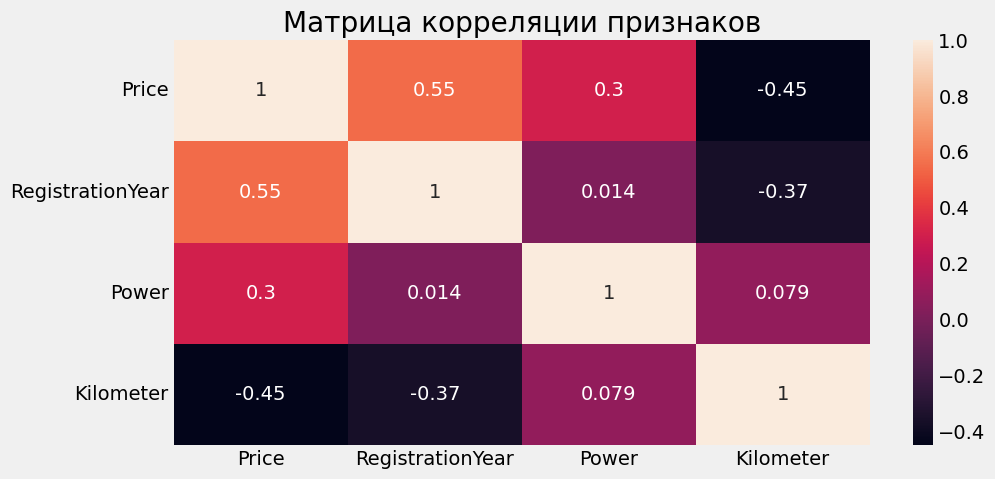

In [49]:
# построим матрицу корреляции остальных количественных признаков

plt.figure(figsize=(10,5))
plt.title('Матрица корреляции признаков')
sns.heatmap(data.corr(), annot = True)

plt.show()

После удаления неинформативных признаков, значительно возросла корреляция между годом регистрации и ценой,  а также мощностью и ценой на авто. Также осталась сильная корреляция с пробегом.

## Обучение моделей

Создадим переменные для признаков и целевого признака.Разделим исходные данные на обучающую, валидационную и тестовую выборки. Данные разобьем на 3 части, в соотношении 60:20:20. Для оптимального подбора гиперпараметров будем использовать GridSearchCV.

Для оценки качества моделей будем применять метрику RMSE (cреднеквадратичная ошибка). Ее значение должно быть меньше 2500.

Исходя из целей, которые важны заказчику (качество предсказания,время обучения модели,время предсказания модели), будем рассчитывать эти показатели для каждой модели и по итогам выберем лучшую.

**Модель CatBoost**

In [50]:
# создадим переменные для целевого признака и для признаков
target = data['Price']
features = data.drop('Price', axis=1)

# разобъем данные на обучающую и валидационную выборки в соотношении 60:20:20
data_train, data_other = train_test_split(data, test_size=0.4, random_state=12345)

# разделим данные на тестовую и валидационную выборки
data_test,data_valid = train_test_split(data_other, test_size=0.5, random_state=12345)


# проверим размеры выборок
data_train.shape, data_test.shape,data_valid.shape


((110320, 10), (36774, 10), (36774, 10))

Создадим переменные для признаков и целевого признака для всех выборок.

In [51]:
# создали переменную features_train, куда сохранили признаки для обучающей выборки
features_train = data_train.drop(['Price'], axis=1)

# создали переменную target_train, куда сохранили целевой признак для обучающей выборки
target_train = data_train['Price']

features_valid = data_valid.drop(['Price'], axis=1) # признаки для валидационной выборки
target_valid = data_valid['Price']                 # целевой признак для валидационной выборки

features_test = data_test.drop(['Price'], axis=1) # признаки для тестовой выборки
target_test = data_test['Price']                  # целевой признак для тестовой выборки

# выведем на экран размеры таблиц, которые хранятся в 6-ти переменных
features_train.shape,target_train.shape,features_valid.shape,target_valid.shape,features_test.shape,target_test.shape


((110320, 9), (110320,), (36774, 9), (36774,), (36774, 9), (36774,))

In [52]:
# инициализируем модель CatBoostRegressor
cb = CatBoostRegressor(loss_function='RMSE',
                       random_state=12345,
                       verbose=False,iterations=200)

In [53]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = ['VehicleType', 'Gearbox', 'Model','FuelType','Brand','Repaired']

In [54]:
%%time
# обучим модель
cb.fit(features_train, target_train,
       cat_features = cat_features,verbose=100)

Learning rate set to 0.318553
0:	learn: 3951.6060261	total: 230ms	remaining: 45.8s
100:	learn: 1750.3012578	total: 13.3s	remaining: 13.1s
199:	learn: 1683.4176048	total: 25.9s	remaining: 0us
CPU times: user 40 s, sys: 639 ms, total: 40.7 s
Wall time: 26.4 s


In [55]:
%%time
# получим предсказания модели
cb_pred = cb.predict(features_valid)

CPU times: user 203 ms, sys: 2.02 ms, total: 205 ms
Wall time: 130 ms


In [56]:
# рассчитаем метрику качества RMSE
cb_mse = mse(target_valid,cb_pred)
print(f'RMSE для CatBoostRegressor:{cb_mse**0.5}')

RMSE для CatBoostRegressor:1760.5137333839343


In [57]:
# подберем гиперпараметры, используя  GridSearchCV

param_grid = {'learning_rate': [0.01, 0.15],
        'depth': [3,12],
        'iterations': [20,200]}
grid_search_model_cb = GridSearchCV(
    cb, param_grid=param_grid, scoring ='neg_root_mean_squared_error', cv=5)

In [ ]:
%%time
grid_search_model_cb.fit(features_train, target_train,
                  cat_features = cat_features,verbose=10)


In [59]:
# выведем лучшие значения гиперпараметров, полученные на GridSearch

grid_search_model_cb.best_score = grid_search_model_cb.best_score_
print(f'Best params: {grid_search_model_cb.best_params_}')
print(f'RMSE:{- 1 * grid_search_model_cb.best_score_}' )

Best params: {'depth': 12, 'iterations': 200, 'learning_rate': 0.15}
RMSE:1729.843901460024


In [60]:
# инициализируем лучшую модель с подобранными гиперпараметрами
cb_best = CatBoostRegressor(loss_function='RMSE',
                           random_state=12345,
                           verbose=10,iterations=200,
                           learning_rate=0.15, depth=12)

In [61]:
%%time
cb_best.fit(features_train, target_train,
                  cat_features = cat_features,verbose=100)

0:	learn: 4377.0964751	total: 407ms	remaining: 1m 21s
100:	learn: 1585.0398797	total: 41.9s	remaining: 41s
199:	learn: 1471.4712532	total: 1m 25s	remaining: 0us
CPU times: user 2min 16s, sys: 1.23 s, total: 2min 18s
Wall time: 1min 26s


In [62]:
%%time
cb_best_pred = cb_best.predict(features_valid)

CPU times: user 324 ms, sys: 5.91 ms, total: 330 ms
Wall time: 285 ms


In [63]:
cb_вest_mse = mse(target_valid,cb_best_pred)
print(f'RMSE для CatBoostRegressor на валидации:{cb_вest_mse**0.5}')

RMSE для CatBoostRegressor на валидации:1720.3163484492438


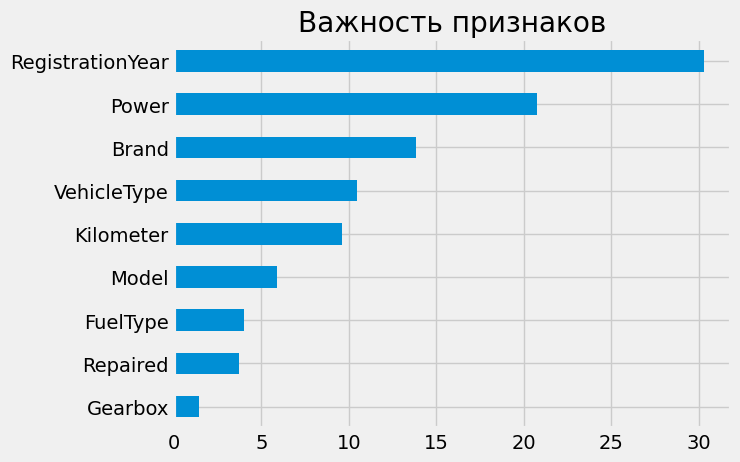

In [64]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния
importances = pd.Series(cb_best.feature_importances_,index=cb_best.feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

**Рассмотрим модель LightGBM**

In [65]:
# инициализируем модель LGBMRegressor
lgbm = LGBMRegressor(objective='mse',random_state=12345)

In [66]:
# обозначим категориальные столбцы для передачи в LightGBM
cat_columns = ['VehicleType', 'Gearbox', 'Model','FuelType','Brand','Repaired']

data[cat_columns] = data[cat_columns].astype("category")

In [67]:
X = data.drop('Price', axis=1)
y = data['Price']

data_train, data_test1 =train_test_split(data, test_size=0.4, random_state=12345)
data_test, data_valid =train_test_split(data_test1, test_size=0.5, random_state=12345)


In [68]:
# создали переменную X_train, куда сохранили признаки для обучающей выборки
X_train = data_train.drop(['Price'], axis=1)

# создали переменную y_train, куда сохранили целевой признак для обучающей выборки
y_train = data_train['Price']

X_valid = data_valid.drop(['Price'], axis=1) # признаки для валидационной выборки
y_valid = data_valid['Price']                 # целевой признак для валидационной выборки

X_test = data_test.drop(['Price'], axis=1) # признаки для тестовой выборки
y_test = data_test['Price']                  # целевой признак для тестовой выборки

# выведем на экран размеры таблиц, которые хранятся в 6-ти переменных
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape


((110320, 9), (110320,), (36774, 9), (36774,), (36774, 9), (36774,))

In [69]:
%%time

# обучим модель на тренировочной выборке
lgbm.fit(X_train, y_train)

CPU times: user 1.83 s, sys: 19.7 ms, total: 1.85 s
Wall time: 1.08 s


LGBMRegressor(objective='mse', random_state=12345)

In [70]:
%%time
# получим предсказания
y_pred = lgbm.predict(X_valid)


CPU times: user 463 ms, sys: 985 µs, total: 464 ms
Wall time: 248 ms


In [71]:
# посчитаем метрику RMSE
lgbm_mse = mse(y_valid, y_pred)
print(f'RMSE для LGBMRegressor:{lgbm_mse**0.5}')

RMSE для LGBMRegressor:1740.9544658079599


Подберем гиперпараметры для модели LightGBM, используя GridSearchCV.

In [72]:
%%time

param_grid = {'learning_rate': [0.01, 0.4],
            'max_depth': [0,12],
            'n_estimators': [20,200]}
grid_search_lgbm = GridSearchCV(lgbm, param_grid=param_grid, scoring ='neg_root_mean_squared_error', cv=5)

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 28.6 µs


In [73]:
%%time

# обучим модель на тренировочной выборке
grid_search_lgbm.fit(X_train, y_train)

CPU times: user 1min 20s, sys: 439 ms, total: 1min 20s
Wall time: 47 s


GridSearchCV(cv=5, estimator=LGBMRegressor(objective='mse', random_state=12345),
             param_grid={'learning_rate': [0.01, 0.4], 'max_depth': [0, 12],
                         'n_estimators': [20, 200]},
             scoring='neg_root_mean_squared_error')

In [74]:
# выведем лучшие гиперпараметры и лучшую RMSE
grid_search_lgbm.best_score = grid_search_lgbm.best_score_
print(f'Best params: {grid_search_lgbm.best_params_}')
print(f'RMSE:{- 1 * grid_search_lgbm.best_score_}' )

Best params: {'learning_rate': 0.4, 'max_depth': 12, 'n_estimators': 200}
RMSE:1746.9220437582128


**Проверим модель LGBMRegressor на валидационной выборке с подобранными гиперпараметрами**

In [75]:
lgbm_best = LGBMRegressor(max_depth=12,
                        n_estimators=200,
                        learning_rate=0.4,
                        objective='mse',
                        random_state=12345)

In [76]:
%%time
# обучим модель на тренировочной выборке
lgbm_best.fit(X_train, y_train)

CPU times: user 2.18 s, sys: 19.9 ms, total: 2.2 s
Wall time: 1.19 s


LGBMRegressor(learning_rate=0.4, max_depth=12, n_estimators=200,
              objective='mse', random_state=12345)

In [77]:
%%time
lgbm_pred = lgbm_best.predict(X_valid)

CPU times: user 504 ms, sys: 2 ms, total: 506 ms
Wall time: 280 ms


In [78]:
lgbm_best_mse = mse(y_valid, lgbm_pred)
print("RMSE для лучшей LGBMRegressor на валидации:", lgbm_best_mse**0.5)

RMSE для лучшей LGBMRegressor на валидации: 1734.9661947505035


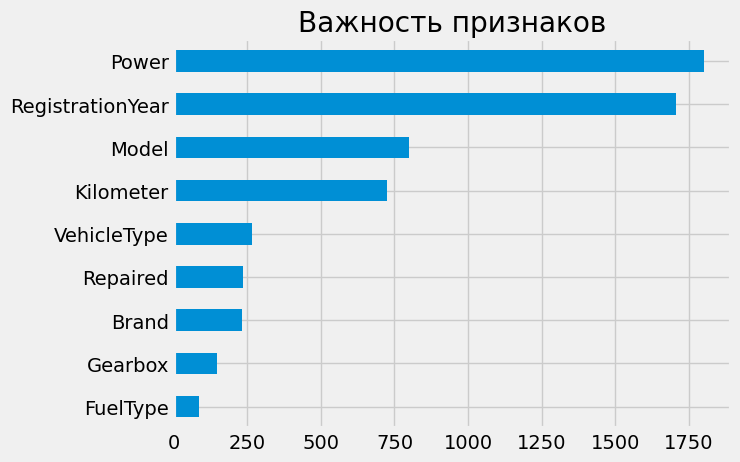

In [79]:
# построим гистограмму значимости признаков для модели LightGBM
# значения отсортированные по возрастанию влияния
importances2 = pd.Series(lgbm_best.feature_importances_,index=lgbm_best.feature_name_).sort_values()

# график
importances2.plot.barh(grid=True, title='Важность признаков');

**Рассмотрим модель случайного леса регрессии RandomForestRegressor**

In [80]:
# категориальные признаки для OHE
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее не встречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore',sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_rf = features_train.drop(ohe_features, axis=1)

# смотрим на результат
features_train_rf.head()

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x4_seat,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_volkswagen,x4_volvo,x5_unknown,x5_yes
127972,2011,114,80000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96891,2005,224,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123872,2006,163,20000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24403,2006,83,90000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17855,2006,163,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [81]:
# энкодером, который обучен на тренировочной, кодируем валидационную
features_valid[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_valid[ohe_features])
features_valid_rf = features_valid.drop(ohe_features, axis=1)

# энкодером, который обучен на тренировочной, кодируем тестовую
features_test[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test[ohe_features])
features_test_rf = features_test.drop(ohe_features, axis=1)

In [82]:
# проверим размеры
features_train_rf.shape,features_test_rf.shape,features_valid_rf.shape

((110320, 296), (36774, 296), (36774, 296))

In [83]:
# инициализируем модель RandomForestRegressor
model_rf_r = RandomForestRegressor(random_state=12345)

In [84]:
%%time

# обучим модель на тренировочной выборке
model_rf_r.fit(features_train_rf,target_train)

CPU times: user 4min 17s, sys: 1.94 s, total: 4min 18s
Wall time: 4min 19s


RandomForestRegressor(random_state=12345)

In [85]:
%%time

# получим предсказания
rf_pred = model_rf_r.predict(features_valid_rf)

CPU times: user 2.21 s, sys: 63.9 ms, total: 2.28 s
Wall time: 2.28 s


In [86]:
# посчитаем метрику RMSE
model_rf_r_mse = mse(target_valid, rf_pred)
print(f'RMSE для RandomForestRegressor:{model_rf_r_mse**0.5}')

RMSE для RandomForestRegressor:1793.279324461955


In [87]:
# попробуем подобрать гиперпараметры
rf = RandomForestRegressor()
param_grid = { 'n_estimators': range (20,40,10),
              'max_depth': range (2,12,2) }

In [88]:
%%time
gr_rf = GridSearchCV(rf, param_grid = param_grid,scoring ='neg_root_mean_squared_error', cv=5)

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 37.2 µs


In [89]:
%%time
gr_rf.fit(features_train_rf,target_train)

CPU times: user 16min 37s, sys: 7.27 s, total: 16min 44s
Wall time: 16min 46s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(2, 12, 2),
                         'n_estimators': range(20, 40, 10)},
             scoring='neg_root_mean_squared_error')

In [90]:
%%time

# выведем лучшие гиперпараметры и лучшую RMSE
gr_rf.best_score = gr_rf.best_score_
print(f'Best params: {gr_rf.best_params_}')
print(f'RMSE:{- 1 * gr_rf.best_score_}' )

Best params: {'max_depth': 10, 'n_estimators': 30}
RMSE:2054.4064881794397
CPU times: user 175 µs, sys: 2 µs, total: 177 µs
Wall time: 182 µs


In [91]:
# инициализируем лучшую модель
model_best_rf = RandomForestRegressor(random_state=12345,max_depth=10, n_estimators=30)

In [92]:
%%time

# обучим модель на тренировочной выборке
model_best_rf.fit(features_train_rf,target_train)

CPU times: user 46 s, sys: 122 ms, total: 46.1 s
Wall time: 46.3 s


RandomForestRegressor(max_depth=10, n_estimators=30, random_state=12345)

In [93]:
%%time

# получим предсказания
best_rf_pred = model_best_rf.predict(features_valid_rf)

CPU times: user 200 ms, sys: 27.9 ms, total: 228 ms
Wall time: 225 ms


In [94]:
# посчитаем метрику RMSE
model_best_rf_mse = mse(target_valid, best_rf_pred)
print(f'RMSE на тестовой выборке:{model_best_rf_mse**0.5}')

RMSE на тестовой выборке:2055.7479205411664


**Проверим модель на адекватность**

In [95]:
dummy_model = DummyRegressor(strategy="mean")


dummy_model.fit(features_train_rf, target_train)
dummy_predictions = dummy_model.predict(features_test_rf)


dummy_model_mse = mse(target_test,dummy_predictions)

print(f'DummyRegressor:{dummy_model_mse**0.5}')

DummyRegressor:4885.853651115121


Провели проверку на адекватность моделей. Mетрика RMSE у дамми модели гораздо выше, чем на всех наших моделях на тестовой выборке. Это говорит нам о том, что наши модели прошли проверку на адекватность.

## Анализ моделей

Мы провели обучение разных моделей, 2 из которых бустинговые - CatBoostRegressor и LGBMRegressor. Для сравнения также была выбрана модель случайного леса регрессии RandomForestRegressor.
В итоге мы получили следующие характеристики у моделей:

* по качеству предсказаний все модели показали значения RMSE ниже требуемого по условию проекта, самое лучшее значение на валидации у CatBoostRegressor - 1720;

* по времени обучения лидирует LGBMRegressor - 1,19 s.,за ней следует  RandomForestRegressor - 47.1s.;
* по времени предсказания самый лучший результат у RandomForestRegressor - 225ms;

Исходя из критериев которые важны заказчику, **рекомендуем компании выбрать модель LGBMRegressor**, т.к. она показывает схожее с CatBoostRegressor лучшее качество и по времени обучения на первом месте среди трех исследованных моделей. Время предсказания у нее чуть больше остальных - 280 ms, но в целом достаточно быстрое.

### Тестирование лучшей модели

Выведем результаты обучения и получения предсказания моделей по времени.

In [97]:
# инициализируем модель LGBMRegressor c лучшим значением метрики RMSE на валидации

lgbm_final = LGBMRegressor(max_depth=12,
                        n_estimators=200,
                        learning_rate=0.4,
                        objective='mse',
                        random_state=12345)

In [98]:
%%time
lgbm_final.fit(X_train, y_train)

CPU times: user 5.94 s, sys: 29.6 ms, total: 5.97 s
Wall time: 5.05 s


LGBMRegressor(learning_rate=0.4, max_depth=12, n_estimators=200,
              objective='mse', random_state=12345)

In [99]:
%%time
predicted_lgbm_final = lgbm_final.predict(X_test)

CPU times: user 556 ms, sys: 2.99 ms, total: 559 ms
Wall time: 314 ms


In [103]:
lgbm_final_mse = mse(y_test, predicted_lgbm_final)
print(f'RMSE для лучшей LGBMRegressor на тесте:{lgbm_final_mse**0.5}')

RMSE для лучшей LGBMRegressor на тесте:1723.0248357523


Выведем результаты обучения и получения предсказания моделей по времени.

In [104]:
pd.DataFrame({
        'Model':['CatBoostRegressor','LGBMRegressor','RandomForestRegressor','Final_LGBMRegressor'],
        'time_fit':['1min26s','1.19s','46.3s','5.05s'],
        'time_pred':['285ms','280ms','225ms','314ms'],
        'RMSE':['1720','1734','2055','1723']
})


,Model,time_fit,time_pred,RMSE
0,CatBoostRegressor,1min26s,285ms,1720
1,LGBMRegressor,1.19s,280ms,1734
2,RandomForestRegressor,46.3s,225ms,2055
3,Final_LGBMRegressor,5.05s,314ms,1723


**Вывод**   

Мы провели работу по подготовке прототипа модели машинного обучения для авто компании.

**Цель анализа:** построение модели для задачи регрессии, которая позволит спрогнозировать рыночную стоимость автомобиля. Это позволит  компании разработать собственное приложение, чтобы привлечь новых клиентов. Для оценки качества моделей была использована метрика RMSE.

В нашем распоряжении были  данные о технических характеристиках, комплектации и ценах других автомобилей. Данные находились в одном файле. В ходе работы был проведен обзор первоначальных данных и их предобработка. Найденные пропуски были заполнены значениями "other". Дубликаты удалены. Неинформативные столбцы были удалены, т.к. не представляют важности при обучении модели. Аномалии в данных обработаны.

Также мы провели анализ данных и визуализировали с помощью графиков результаты зависимости цены авто от различных характеристик и комплектаций.

В данном исследовании мы инициализировали модели на основе градиентного бустинга CatBoostRegressor и LGBMRegressor, а также посмотрели более простую модель - случайного леса регрессии. Качество моделей мы оценивали подсчетом метрики RMSE. Для улучшения качества моделей мы подбирали гиперпараметры, используя GridSearch. Выбрав лучшую модель, мы рассчитали ее качество на тестовой выборке.

Исходя из критериев которые важны заказчику, **рекомендуем компании выбрать модель LGBMRegressor** с подобранными гиперпараметрами
(LGBMRegressor(max_depth=12,
              n_estimators=200,
              learning_rate=0.4,
              objective='mse',
              random_state=12345), т.к. она показывает самое лучшее качество на тесте (RMSE 1723) и по времени обучения (5.05 s) на втором месте среди трех исследованных моделей. Время предсказания у нее чуть больше остальных - 314 ms, но в целом достаточно быстрое.